# Connection to AWS Redshift

In [ ]:
!pip install "redshift_connector[full]"

Defaulting to user installation because normal site-packages is not writeable


In [ ]:
import pandas as pd
import os
import redshift_connector

In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt

In [ ]:
conn = redshift_connector.connect(
    host='cspc-workgroup.783764604578.us-west-2.redshift-serverless.amazonaws.com',
    database='cspc5071-dsa',
    port=5439,
    user='python_user',
    password='Database123!' # Not best practice but who cares :))
 )
cursor = conn.cursor()

In [ ]:
# Query to get the list of tables in the specified schema
query = f"""
SELECT table_name
FROM information_schema.tables
WHERE table_schema = 'public'
AND table_type = 'BASE TABLE';
"""

cursor.execute(query)
tables = cursor.fetchall()

print(f"Tables in schema public:")
for table in tables:
    print(table[0]) # These are all the data we have in AWS redshift. I'm getting infinite loading screen, so I wanted to just see

Tables in schema public:
average_egg_price
us_national_outbreaks
h5n1_outbreaks
us_national_disaster
covid_hospitalization


# Data preprocessing - Price Data (Dan)

In [ ]:
query = """SELECT * FROM "average_egg_price";
"""
cursor.execute(query)
df_egg_price : pd.DataFrame = cursor.fetch_dataframe()

In [ ]:
df_egg_price['observation_date'] = pd.to_datetime(df_egg_price['observation_date'])
df_egg_price['date'] = df_egg_price['observation_date'].dt.to_period('M')

In [ ]:
df_egg_price

,observation_date,price_per_dozen,date
0,1980-01-01,0.879,1980-01
1,1980-02-01,0.774,1980-02
2,1980-03-01,0.812,1980-03
3,1980-04-01,0.797,1980-04
4,1980-05-01,0.737,1980-05
...,...,...,...
536,2024-09-01,3.821,2024-09
537,2024-10-01,3.370,2024-10
538,2024-11-01,3.649,2024-11
539,2024-12-01,4.146,2024-12


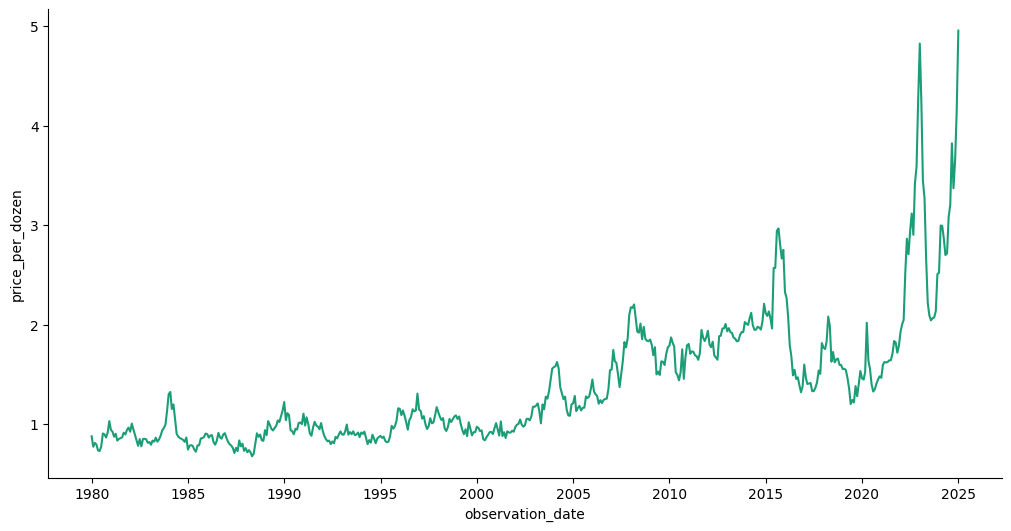

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['observation_date']
  ys = series['price_per_dozen']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df_egg_price.sort_values('observation_date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('observation_date')
_ = plt.ylabel('price_per_dozen')

# Data preprocessing - Human Disease Outbreak (Dan)

## US diseases excluding pandemics

In [ ]:
query = """SELECT year, month, primary_mode, etiology, illnesses, food_vehicle, animal_type FROM "cspc5071-dsa"."public"."us_national_outbreaks";
"""
cursor.execute(query)
df_us_outbreaks : pd.DataFrame = cursor.fetch_dataframe()

In [ ]:
df_us_outbreaks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66709 entries, 0 to 66708
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   year          66709 non-null  int64 
 1   month         66709 non-null  int64 
 2   primary_mode  66709 non-null  object
 3   etiology      66709 non-null  object
 4   illnesses     66709 non-null  int64 
 5   food_vehicle  66709 non-null  object
 6   animal_type   66709 non-null  object
dtypes: int64(3), object(4)
memory usage: 3.6+ MB


In [ ]:
df_us_outbreaks['date'] = df_us_outbreaks['year'].astype(str) + '-' + df_us_outbreaks['month'].astype(str)

In [ ]:
df_us_outbreaks['datetime'] = pd.to_datetime(df_us_outbreaks['date'], format='%Y-%m', errors='coerce')
df_us_outbreaks['date'] = df_us_outbreaks['datetime'].dt.strftime('%Y-%m')

In [ ]:
df_us_outbreaks

,year,month,primary_mode,etiology,illnesses,food_vehicle,animal_type,date,datetime
0,2023,1,Food,Norovirus Genogroup IX,23,,,2023-01,2023-01-01
1,2023,1,Indeterminate/unknown,Norovirus,7,,,2023-01,2023-01-01
2,2023,1,Person-to-person,Norovirus unknown,23,,,2023-01,2023-01-01
3,2023,1,Person-to-person,Norovirus unknown;Clostridium difficile,12,,,2023-01,2023-01-01
4,2023,1,Person-to-person,,9,,,2023-01,2023-01-01
...,...,...,...,...,...,...,...,...,...
66704,1971,11,Water,Shigella sonnei,89,,,1971-11,1971-11-01
66705,1971,11,Water,Unknown,750,,,1971-11,1971-11-01
66706,1971,11,Water,Hepatitis A,50,,,1971-11,1971-11-01
66707,1971,11,Water,Hepatitis A,3,,,1971-11,1971-11-01


In [ ]:
df_us_outbreaks_grouped = df_us_outbreaks.groupby('date', as_index=False).agg(
    us_human_outbreaks_cnt = pd.NamedAgg(column='illnesses', aggfunc='count'),
    us_human_illnesses_cnt = pd.NamedAgg(column='illnesses', aggfunc='sum')
)

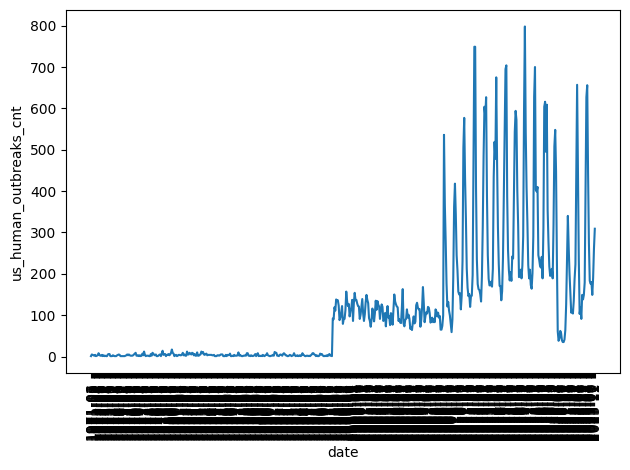

In [ ]:
sns.lineplot(df_us_outbreaks_grouped, x='date', y='us_human_outbreaks_cnt')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
# Join with US population to normalize data
query = """SELECT * FROM "cspc5071-dsa"."public"."us_population";
"""
cursor.execute(query)
df_us_population : pd.DataFrame = cursor.fetch_dataframe()

In [ ]:
df_us_population['date'] = pd.to_datetime(df_us_population['date'].astype(str), format='%Y-%m-%d').dt.strftime('%Y-%m')

In [ ]:
df_us_outbreaks_grouped = df_us_outbreaks_grouped.merge(df_us_population, on='date', how='left')

In [ ]:
df_us_outbreaks_grouped = df_us_outbreaks_grouped.loc[df_us_outbreaks_grouped['date'] > '1980-01']

In [ ]:
df_us_outbreaks_grouped['population_million'] = df_us_outbreaks_grouped['population_million'].fillna(method='bfill')

In [ ]:
df_us_outbreaks_grouped['us_human_illnesses_per_million'] = df_us_outbreaks_grouped['us_human_illnesses_cnt']/df_us_outbreaks_grouped['population_million']

C:\Users\thanh\AppData\Local\Temp\ipykernel_9136\1548923575.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_us_outbreaks_grouped['us_human_illnesses_per_million'] = df_us_outbreaks_grouped['us_human_illnesses_cnt']/df_us_outbreaks_grouped['population_million']


In [ ]:
df_us_outbreaks_grouped

,date,us_human_outbreaks_cnt,us_human_illnesses_cnt,population_million,us_human_illnesses_per_million
92,1980-03,6,657,227.220001,2.891471
93,1980-04,3,48,227.220001,0.211249
94,1980-05,5,282,227.220001,1.241088
95,1980-06,9,10016,227.220001,44.080626
96,1980-07,17,3378,227.220001,14.866649
...,...,...,...,...,...
594,2023-08,180,2205,337.100006,6.541086
595,2023-09,149,3368,337.410004,9.981921
596,2023-10,190,4087,337.700012,12.102457
597,2023-11,261,5343,337.989990,15.808160


<Axes: xlabel='us_human_illnesses_per_million', ylabel='Count'>

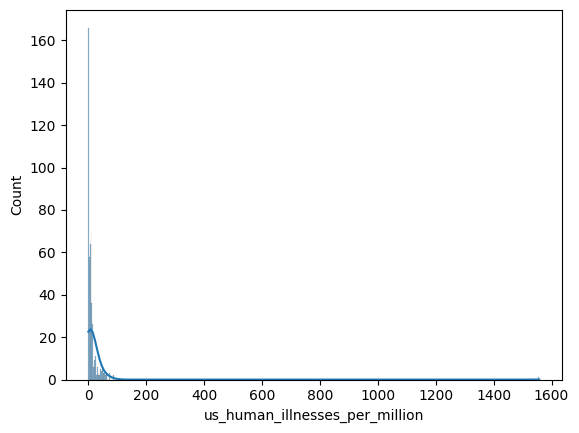

In [ ]:
sns.histplot(df_us_outbreaks_grouped, x='us_human_illnesses_per_million', kde=True)

## Pandemics



*   2002-2004 SARS
*   2009-2010 Swine Flu
*   2012-Present Mers
*   2019-Present Covid-19





In [ ]:
# Covid Hospitalization
query = """SELECT * FROM "cspc5071-dsa"."public"."covid_hospitalization";"""
cursor.execute(query)
df_covid : pd.DataFrame = cursor.fetch_dataframe()

In [ ]:
df_covid_us = df_covid[df_covid['entity'] == 'United States'].copy()

In [ ]:
df_covid_us['date'] = ((pd.to_datetime(df_covid_us['day'])).dt.to_period('M')).dt.strftime('%Y-%m')

In [ ]:
df_covid_us = df_covid_us.groupby('date', as_index=False)['daily_hospital_occupancy'].mean().rename(columns={'daily_hospital_occupancy':'AVG_us_pandemic_illnesses'})

In [ ]:
df_covid_us = df_covid_us.merge(df_us_population, on='date', how='left')

In [ ]:
df_covid_us['us_pandemi_illnesses_per_million'] = df_covid_us['AVG_us_pandemic_illnesses']/df_covid_us['population_million']

In [ ]:
df_covid_us

,date,AVG_us_pandemic_illnesses,population_million,us_pandemi_illnesses_per_million
0,2020-07,43733.176471,331.579987,131.893293
1,2020-08,39053.935484,331.649994,117.756479
2,2020-09,27433.766667,331.730011,82.699080
3,2020-10,35269.225806,331.809998,106.293439
4,2020-11,70459.833333,331.880005,212.305147
5,2020-12,109812.161290,331.890015,330.869133
6,2021-01,117322.677419,331.850006,353.541285
7,2021-02,65467.392857,331.779999,197.321698
8,2021-03,36149.387097,331.799988,108.949332
9,2021-04,37859.200000,331.859985,114.081847


# Data preprocessing - Natural Disaster (Sung)

In [ ]:
query = """SELECT * FROM "cspc5071-dsa"."public"."us_national_disaster";
"""
cursor.execute(query)
df_us_disasters : pd.DataFrame = cursor.fetch_dataframe()

copied_df = df_us_disasters.copy() # creating a deep copy so I don't have to fetch the database all the time

In [ ]:
df_us_disasters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 403 entries, 0 to 402
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               403 non-null    object 
 1   disaster_type      403 non-null    object 
 2   start_date         403 non-null    object 
 3   end_date           403 non-null    object 
 4   cpi_adjsuted_cost  403 non-null    float64
 5   unadjusted_cost    403 non-null    float64
 6   deaths             403 non-null    int64  
dtypes: float64(2), int64(1), object(4)
memory usage: 22.2+ KB


In [ ]:
# Changing date in format of 'YYYYMMDD' to 'YYYY-MM'
from datetime import datetime

df_us_disasters['start_date'] = pd.to_datetime(df_us_disasters['start_date'].astype(str), format='%Y%m%d').dt.strftime('%Y-%m')
df_us_disasters['end_date'] = pd.to_datetime(df_us_disasters['end_date'].astype(str), format='%Y%m%d').dt.strftime('%Y-%m')

In [ ]:
df_us_disasters.head()

,name,disaster_type,start_date,end_date,cpi_adjsuted_cost,unadjusted_cost,deaths
0,Southern Severe Storms and Flooding (April 1980),Flooding,1980-04,1980-04,2749.399902,706.799988,7
1,Hurricane Allen (August 1980),Tropical Cyclone,1980-08,1980-08,2236.199951,590.000000,13
2,Central/Eastern Drought/Heat Wave (Summer-Fall...,Drought,1980-06,1980-11,40681.199219,10020.000000,1260
3,Florida Freeze (January 1981),Freeze,1981-01,1981-01,2076.399902,572.000000,0
4,"Severe Storms, Flash Floods, Hail, Tornadoes (...",Severe Storm,1981-05,1981-05,1409.099976,401.399994,20


In [ ]:
def expand_date_range(row):
    date_range = pd.date_range(row["start_date"], row["end_date"], freq="MS").strftime("%Y-%m")
    num_months = len(date_range)

    return pd.DataFrame({
        "name": row["name"],
        "disaster_type": row["disaster_type"],
        "date": date_range,
        "cpi_adjusted_cost": row["cpi_adjsuted_cost"] / num_months,
        "unadjusted_cost": row["unadjusted_cost"] / num_months,
        "deaths": row["deaths"] / num_months
    })

df_us_disasters = pd.concat(df_us_disasters.apply(expand_date_range, axis=1).to_list(), ignore_index=True)
df_us_disasters.head(10)

,name,disaster_type,date,cpi_adjusted_cost,unadjusted_cost,deaths
0,Southern Severe Storms and Flooding (April 1980),Flooding,1980-04,2749.399902,706.799988,7.0
1,Hurricane Allen (August 1980),Tropical Cyclone,1980-08,2236.199951,590.000000,13.0
2,Central/Eastern Drought/Heat Wave (Summer-Fall...,Drought,1980-06,6780.199870,1670.000000,210.0
3,Central/Eastern Drought/Heat Wave (Summer-Fall...,Drought,1980-07,6780.199870,1670.000000,210.0
4,Central/Eastern Drought/Heat Wave (Summer-Fall...,Drought,1980-08,6780.199870,1670.000000,210.0
5,Central/Eastern Drought/Heat Wave (Summer-Fall...,Drought,1980-09,6780.199870,1670.000000,210.0
6,Central/Eastern Drought/Heat Wave (Summer-Fall...,Drought,1980-10,6780.199870,1670.000000,210.0
7,Central/Eastern Drought/Heat Wave (Summer-Fall...,Drought,1980-11,6780.199870,1670.000000,210.0
8,Florida Freeze (January 1981),Freeze,1981-01,2076.399902,572.000000,0.0
9,"Severe Storms, Flash Floods, Hail, Tornadoes (...",Severe Storm,1981-05,1409.099976,401.399994,20.0


In [ ]:
df_us_disasters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 754 entries, 0 to 753
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               754 non-null    object 
 1   disaster_type      754 non-null    object 
 2   date               754 non-null    object 
 3   cpi_adjusted_cost  754 non-null    float64
 4   unadjusted_cost    754 non-null    float64
 5   deaths             754 non-null    float64
dtypes: float64(3), object(3)
memory usage: 35.5+ KB


## Statistics

In [ ]:
print(df_us_disasters.describe())

       cpi_adjusted_cost  unadjusted_cost       deaths
count         754.000000       754.000000   754.000000
mean         3868.517369      2732.225072    22.437666
std         12982.182295      9769.737817   132.695852
min           194.400004       120.833333     0.000000
25%           850.158366       500.533325     0.000000
50%          1542.400024      1000.930589     3.000000
75%          2649.550049      1917.149963    12.375000
max        201297.500000    125029.500000  2981.000000


## EDA

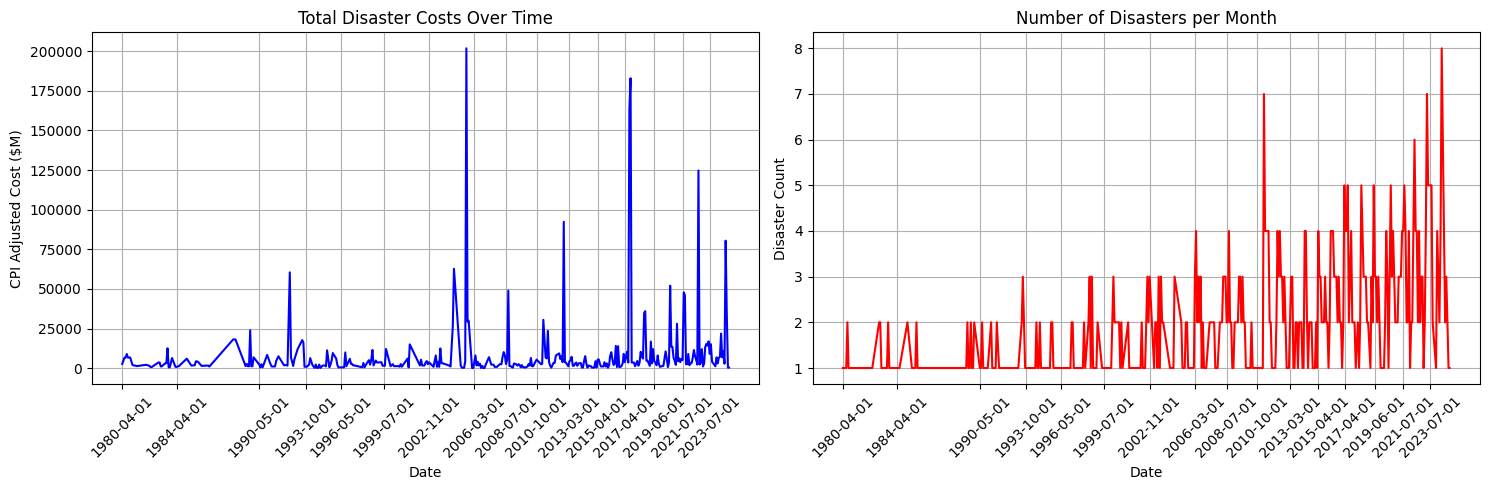

In [ ]:
monthly_cost = df_us_disasters.groupby("date")["cpi_adjusted_cost"].sum()  # Total Disaster Costs Over Time
monthly_disasters = df_us_disasters.groupby("date")["name"].count() # Count number of disasters per month

monthly_cost.index = pd.to_datetime(monthly_cost.index)
monthly_disasters.index = pd.to_datetime(monthly_disasters.index)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# Total Disaster Costs Over Time
axes[0].plot(monthly_cost, label="Total Cost", color="b")
axes[0].set_title("Total Disaster Costs Over Time")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("CPI Adjusted Cost ($M)")
axes[0].set_xticks(monthly_cost.index[::18])
axes[0].tick_params(axis="x", rotation=45)
axes[0].grid()

# Number of Disasters per Month
axes[1].plot(monthly_disasters, label="Disaster Count", color="r")
axes[1].set_title("Number of Disasters per Month")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Disaster Count")
axes[1].set_xticks(monthly_disasters.index[::24])
axes[1].tick_params(axis="x", rotation=45)
axes[1].grid()

plt.tight_layout()
plt.show()

<ipython-input-58-8ead105c15eb>:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
<ipython-input-58-8ead105c15eb>:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)


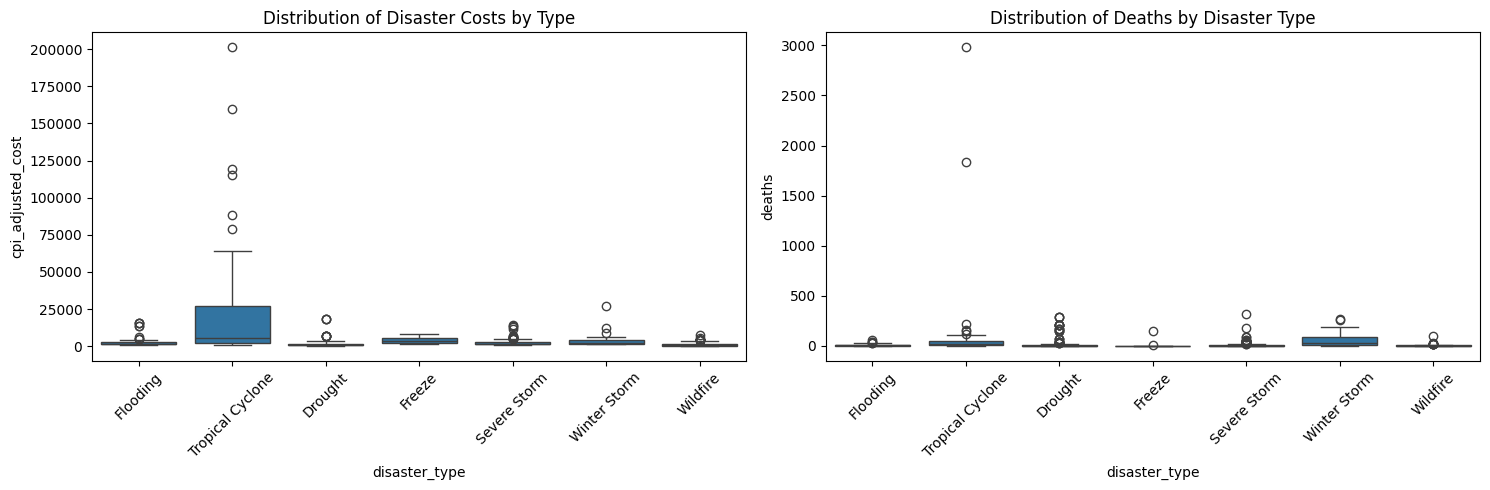

In [ ]:
import seaborn as sns
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# Cost Distribution by Disaster Type
sns.boxplot(data=df_us_disasters, x="disaster_type", y="cpi_adjusted_cost", ax=axes[0])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
axes[0].set_title("Distribution of Disaster Costs by Type")

# Death Distribution by Disaster Type
sns.boxplot(data=df_us_disasters, x="disaster_type", y="deaths", ax=axes[1])
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)
axes[1].set_title("Distribution of Deaths by Disaster Type")

plt.tight_layout()
plt.show()

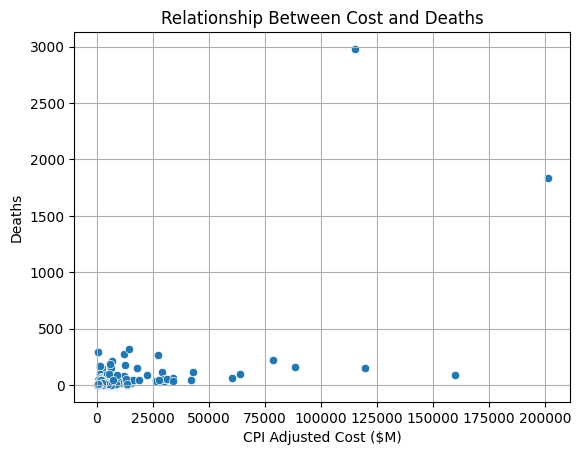

In [ ]:
sns.scatterplot(data=df_us_disasters, x="cpi_adjusted_cost", y="deaths")
plt.title("Relationship Between Cost and Deaths")
plt.xlabel("CPI Adjusted Cost ($M)")
plt.ylabel("Deaths")
plt.grid()
plt.show()

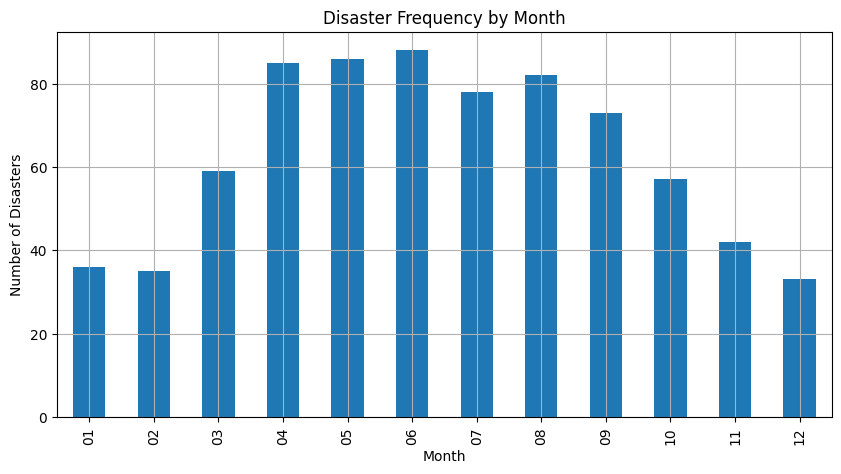

In [ ]:
copy_df = df_us_disasters.copy()

copy_df["month"] = copy_df["date"].str[5:7]  # Extract month
seasonal_counts = copy_df["month"].value_counts().sort_index()

plt.figure(figsize=(10, 5))
seasonal_counts.plot(kind="bar")
plt.title("Disaster Frequency by Month")
plt.xlabel("Month")
plt.ylabel("Number of Disasters")
plt.grid()
plt.show()

## Feature Creation

# Data Preprocessing - H5N1 Outbreak (Chris)

In [ ]:
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls drive/MyDrive/

'Colab Notebooks'		  h5n1-flu-reported-cases-filtered.csv	   Resume.gdoc
 commercial-backyard-flocks.csv   h5n1-flu-reported-cases-unfiltered.csv   Resume.pdf
 cs5071project			  images				   TW2
 data-table.csv			 'Resume (1).pdf'			  'Untitled document.gdoc'


In [ ]:
# query = """SELECT * FROM "h5n1_outbreaks";
# """
# cursor.execute(query)
# df_af : pd.DataFrame = cursor.fetch_dataframe()

df_af = pd.read_csv("/content/drive/MyDrive/data-table.csv")
df_af.head()

,FullGeoName,FIPS Codes,County Name,State,Outbreak Date,Flock Type,Flock Size,State Count,Outbreaks,Counties
0,"MI, Jackson",26075,Jackson,Michigan,12-31-2024,WOAH Non-Poultry,9,1,1,1
1,"CA, Riverside",6065,Riverside,California,12-31-2024,Commercial Table Egg Layer; WOAH Non-Poultry; ...,1503370,1,5,1
2,"CA, Butte",6007,Butte,California,12-31-2024,WOAH Non-Poultry; Commercial Raised for Releas...,45890,0,4,1
3,"SD, Miner",46097,Miner,South Dakota,12-31-2024,WOAH Poultry,1500,1,1,1
4,"MI, Ottawa",26139,Ottawa,Michigan,12-31-2024,Commercial Turkey Meat Bird,447700,0,7,1


In [ ]:
df_af.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 648 entries, 0 to 647
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   FullGeoName    648 non-null    object
 1   FIPS Codes     648 non-null    int64 
 2   County Name    648 non-null    object
 3   State          648 non-null    object
 4   Outbreak Date  648 non-null    object
 5   Flock Type     648 non-null    object
 6   Flock Size     648 non-null    int64 
 7   State Count    648 non-null    int64 
 8   Outbreaks      648 non-null    int64 
 9   Counties       648 non-null    int64 
dtypes: int64(5), object(5)
memory usage: 50.8+ KB


In [ ]:
df_af['Outbreak Date'] = pd.to_datetime(df_af['Outbreak Date'], format='%m-%d-%Y')
df_af['yyyy_mm'] = df_af['Outbreak Date'].dt.strftime('%Y-%m')

In [ ]:
flocks_impacted = df_af.groupby('yyyy_mm').size().reset_index(name='Flock_Count')
flocks_impacted.head()

,yyyy_mm,Flock_Count
0,2022-02,6
1,2022-03,31
2,2022-04,41
3,2022-05,30
4,2022-06,4


In [ ]:
df_af = df_af.merge(flocks_impacted, on='yyyy_mm', how='left')

In [ ]:
flocks_impacted_size = df_af.groupby('yyyy_mm')['Flock Size'].sum().reset_index(name='Total_Flock_Size')
df_af = df_af.merge(flocks_impacted_size, on='yyyy_mm', how='left')

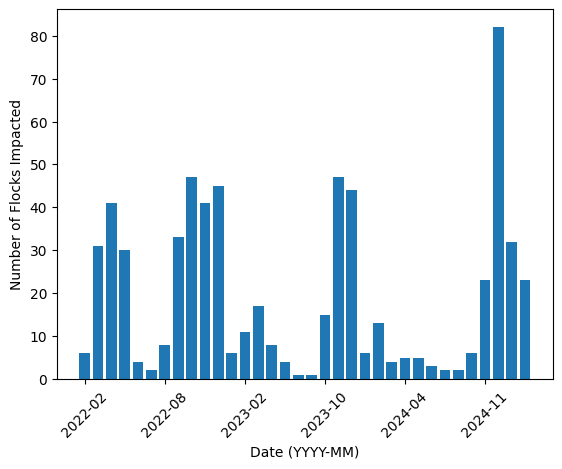

In [ ]:
plt.bar(flocks_impacted['yyyy_mm'], flocks_impacted['Flock_Count'])
tick_positions = flocks_impacted['yyyy_mm'][::6]
plt.xticks(tick_positions, rotation=45)
plt.xlabel('Date (YYYY-MM)')
plt.ylabel('Number of Flocks Impacted')
plt.show()

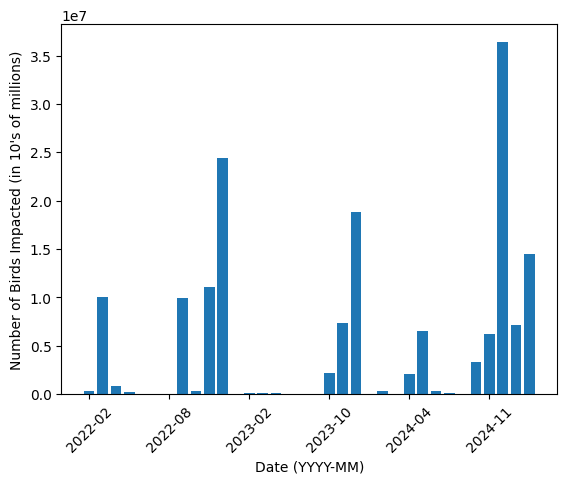

In [ ]:
plt.bar(flocks_impacted_size['yyyy_mm'], flocks_impacted_size['Total_Flock_Size'])
tick_positions = flocks_impacted_size['yyyy_mm'][::6]
plt.xticks(tick_positions, rotation=45)
plt.xlabel('Date (YYYY-MM)')
plt.ylabel('Number of Birds Impacted (in 10\'s of millions)')
plt.show()

In [ ]:
human = pd.read_csv('/content/drive/MyDrive/h5n1-flu-reported-cases-unfiltered.csv')
human.head()

,Entity,Code,Day,Human cases with highly pathogenic avian influenza A/H5N1 (monthly)
0,Africa,NaN,1997-01-01,0
1,Africa,NaN,1997-02-01,0
2,Africa,NaN,1997-03-01,0
3,Africa,NaN,1997-04-01,0
4,Africa,NaN,1997-05-01,0


In [ ]:
human['Human cases with highly pathogenic avian influenza A/H5N1 (monthly)'].unique()

array([ 0, 10,  3,  2,  1,  5,  7,  8,  4,  6, 11, 23, 46, 50, 32, 13, 14,
       19, 12,  9, 30, 17, 21, 16, 47, 51, 37])

In [ ]:
human = human[human['Entity'] == 'United States'].copy()
human

,Entity,Code,Day,Human cases with highly pathogenic avian influenza A/H5N1 (monthly),yyyy_mm
9436,United States,USA,1997-01-01,0,1997-01
9437,United States,USA,1997-01-02,0,1997-01
9438,United States,USA,1997-01-03,0,1997-01
9439,United States,USA,1997-01-04,0,1997-01
9440,United States,USA,1997-01-05,0,1997-01
...,...,...,...,...,...
9768,United States,USA,2024-01-09,1,2024-01
9769,United States,USA,2024-01-10,30,2024-01
9770,United States,USA,2024-01-11,13,2024-01
9771,United States,USA,2024-01-12,9,2024-01


In [ ]:
human['Day'] = pd.to_datetime(human['Day'], format = '%Y-%d-%m')
human['yyyy_mm'] = human['Day'].dt.strftime('%Y-%m')

In [ ]:
people_impacted = human.groupby('yyyy_mm')['Human cases with highly pathogenic avian influenza A/H5N1 (monthly)'].sum().reset_index(name='People_Count')
people_impacted.head()

,yyyy_mm,People_Count
0,1997-01,54
1,1998-01,0
2,1999-01,0
3,2000-01,0
4,2001-01,0


In [ ]:
people_impacted[people_impacted['yyyy_mm'] == '2024-01']

,yyyy_mm,People_Count
27,2024-01,240


In [ ]:
human[human['Day'] == '2024-01-01']

,Entity,Code,Day,Human cases with highly pathogenic avian influenza A/H5N1 (monthly),yyyy_mm
324,Africa,NaN,2024-01-01,0,2024-01
661,Asia,NaN,2024-01-01,2,2024-01
998,Australia,AUS,2024-01-01,0,2024-01
1335,Azerbaijan,AZE,2024-01-01,0,2024-01
1672,Bangladesh,BGD,2024-01-01,0,2024-01
2009,Cambodia,KHM,2024-01-01,2,2024-01
2346,Canada,CAN,2024-01-01,0,2024-01
2683,Chile,CHL,2024-01-01,0,2024-01
3020,China,CHN,2024-01-01,0,2024-01
3357,Djibouti,DJI,2024-01-01,0,2024-01


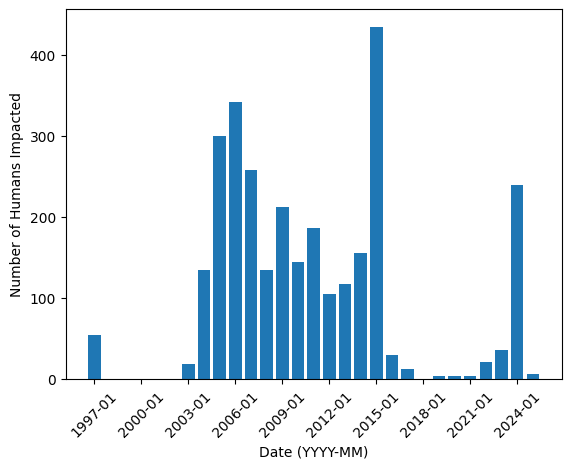

In [ ]:
plt.bar(people_impacted['yyyy_mm'], people_impacted['People_Count'])
tick_positions = people_impacted['yyyy_mm'][::3]
plt.xticks(tick_positions, rotation=45)
plt.xlabel('Date (YYYY-MM)')
plt.ylabel('Number of Humans Impacted')
plt.show()

# Data Preprocessing - Historical Weather Data (Aakash)

## Data Cleaning

In [1]:
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import functools as ft


drive.mount('/content/drive', force_remount=True)



dataWA = pd.read_csv('/content/drive/MyDrive/cpsc5071data/open-meteo-seattle.csv').iloc[2:, 0:2].rename(columns={'latitude':'date', 'longitude':'tempWA'})
dataIN = pd.read_csv('/content/drive/MyDrive/cpsc5071data/open-meteo-indiana.csv').iloc[2:, 0:2].rename(columns={'latitude':'date', 'longitude':'tempIN'})
dataMO = pd.read_csv('/content/drive/MyDrive/cpsc5071data/open-meteo-missouri.csv').iloc[2:, 0:2].rename(columns={'latitude':'date', 'longitude':'tempMO'})
dataWI = pd.read_csv('/content/drive/MyDrive/cpsc5071data/open-meteo-wisconsin.csv').iloc[2:, 0:2].rename(columns={'latitude':'date', 'longitude':'tempWI'})

weather_data = ft.reduce(lambda left,right: pd.merge(left,right,on=['date'],
                                            how='outer'), [dataWA, dataIN, dataMO, dataWI])

print(weather_data)

Mounted at /content/drive
             date tempWA tempIN tempMO tempWI
0      1980-01-01   43.5   28.3   33.5   27.6
1      1980-01-02   39.2   28.9   30.9   25.9
2      1980-01-03   37.2   29.0   28.8   21.9
3      1980-01-04   35.0   26.8   30.4   21.3
4      1980-01-05   32.6   24.9   31.8   21.2
...           ...    ...    ...    ...    ...
16463  2025-01-27   32.6   26.2   32.3   28.2
16464  2025-01-28   32.4   35.3   39.3   33.6
16465  2025-01-29   32.8   35.9   39.5   31.1
16466  2025-01-30   34.4   37.8   44.7   35.2
16467  2025-01-31   42.5   39.5   41.5   31.8

[16468 rows x 5 columns]


In [2]:
weather_data['month'] = weather_data['date'].str[:7]
weather_data[['tempWA', 'tempIN', 'tempMO', 'tempWI']] = weather_data[['tempWA', 'tempIN', 'tempMO', 'tempWI']].apply(pd.to_numeric)

weather_avg = weather_data.groupby('month')[['tempWA', 'tempIN', 'tempMO', 'tempWI']].mean()

print(weather_avg)

            tempWA     tempIN     tempMO     tempWI
month                                              
1980-01  31.851613  26.558065  31.693548  17.232258
1980-02  39.679310  21.993103  28.658621  16.448276
1980-03  41.074194  33.848387  39.796774  26.816129
1980-04  49.163333  48.016667  53.443333  44.306667
1980-05  52.761290  61.393548  64.667742  58.841935
...            ...        ...        ...        ...
2024-09  60.206667  68.690000  70.476667  66.003333
2024-10  51.370968  58.016129  62.941935  54.748387
2024-11  43.463333  46.523333  48.440000  41.140000
2024-12  41.432258  33.738710  38.561290  26.116129
2025-01  36.654839  21.358065  25.474194  17.325806

[541 rows x 4 columns]


## EDA

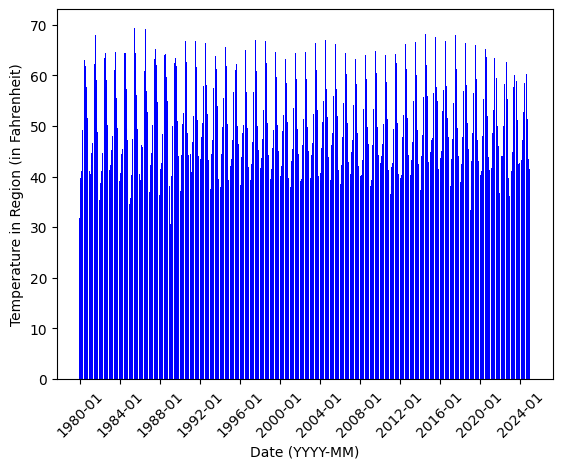

In [3]:
tick_positions = weather_avg.index[::48]

plt.bar(weather_avg.index, weather_avg['tempWA'], color='blue')
plt.xticks(tick_positions, rotation=45)
plt.xlabel('Date (YYYY-MM)')
plt.ylabel('Temperature in Region (in Fahrenheit)')
plt.show()

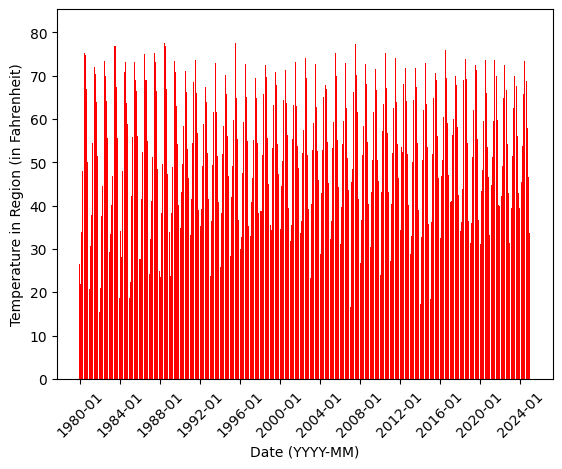

In [4]:
plt.bar(weather_avg.index, weather_avg['tempIN'], color='red')
plt.xticks(tick_positions, rotation=45)
plt.xlabel('Date (YYYY-MM)')
plt.ylabel('Temperature in Region (in Fahrenheit)')
plt.show()

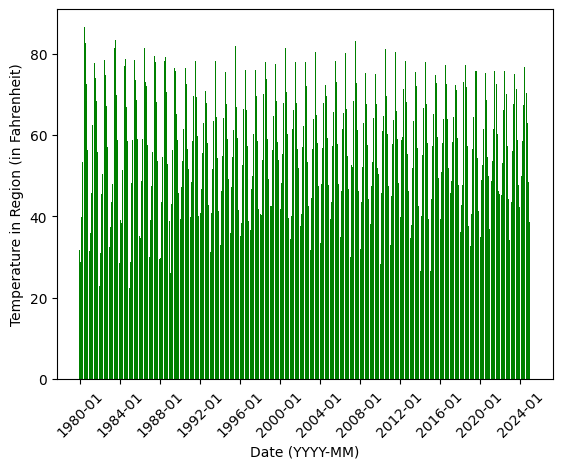

In [5]:
plt.bar(weather_avg.index, weather_avg['tempMO'], color='green')
plt.xticks(tick_positions, rotation=45)
plt.xlabel('Date (YYYY-MM)')
plt.ylabel('Temperature in Region (in Fahrenheit)')
plt.show()

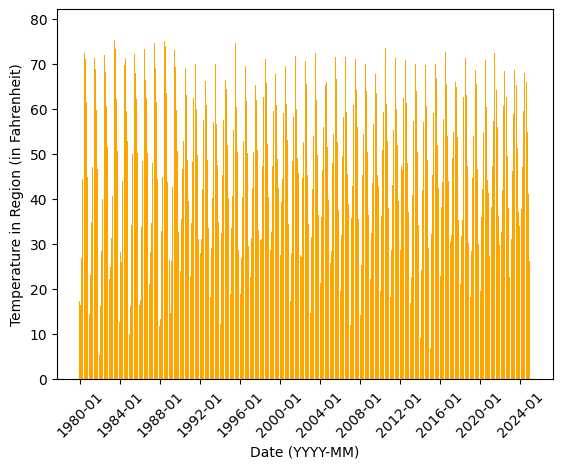

In [6]:
plt.bar(weather_avg.index, weather_avg['tempWI'], color='orange')
plt.xticks(tick_positions, rotation=45)
plt.xlabel('Date (YYYY-MM)')
plt.ylabel('Temperature in Region (in Fahrenheit)')
plt.show()


Observing these weather graphs for each location shows us that locations where eggs are generated such as rural Indiana or Missouri tend to experience more extreme swings in temperatures than a location where egg rearing does not take place, such as Seattle. Wisconsin seems to experience an even larger variation in temperatures than the other two big egg-producing states. This may be a factor affecting egg production. Notably, over recent years, the mean temperatures during winter months are higher than they were in the 80s and 90s, most likely an effect of global warming.